(Sorry about this one Anan - it's dreadful!)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Problem 1

Note: I took several chunks of code from "interferometer_uv.py". I was pretty confused about the steps of this problem, so I tried to comment Jon's code where I used it and explain the methods but I understand if this voids points for this problem!

*(a) Plot the 2D positions of the antennas in NS/EW in ns. Convert the 3D coordinates into 2D coordinates using the local zenith (34.1 degrees). The east unit vector is (0,1,0), get north by taking a suitable cross product. You should see the E/W and N/S spreads are similar and the vertical scatter is much smaller. Report the vertical RMS scatter for both A and D-arrays.*

The zenith vector is $(sin \theta cos \phi, sin \theta sin \phi, cos \theta)$ where we take $\phi = 0$.

*(b) Make a UV plot for the two configurations for a source directly overhead. Assume you're observing in the L-band (1.4 GHz). Axes should be labelled in wavelengths, not meters.*

We get the baselines by subtracting the (x,y,z) vectors from each other but in the new E/W, N/S coordinate system. Then use $\lambda = \frac{c}{\nu}$ with $\nu = 1.4 GHz$ for the baselines $b = uv \lambda$??? 

*(c) Plot the dirty beam for the UV coverage in (b). Report the values for the beam FWHM and compare to the published VLA values.*

For the dirty beam, we put 0's everywhere where there's no measurement and 1's where we do have a measurement. Then (inverse?) Fourier transform that to get the dirty beam.

*(d) Repeat the UV plots, now assume you observe a source for 8 hours, starting 4 hours before the source transits overhead to 4 hours after. Do this for a source that crosses directly overhead, a source on the equator, and a source at the north celestial pole.*

The easiest way to do this is to keep the source's coordinate system and change the baseline vectors in the east-north 2d coordinate system. So for every time step, the Earth rotates by some angle $\phi$ (keeping $\theta = 34.1 $ degrees) which means we rotate (x,y,z) and get new baselines in UV space. 

For a source directly overhead we use latitude: $\theta = 34.1 $ degrees, for a source at the equator we use $\theta = 45$ degrees, and for a source at the north celestial pole we use $\theta = 0$ degrees.

*(e) Plot the synthesized beams for the cases in (d).*

A array: vertical RMS scatter = 19.873410538544693 m
D array: vertical RMS scatter = 0.8127155170471895 m


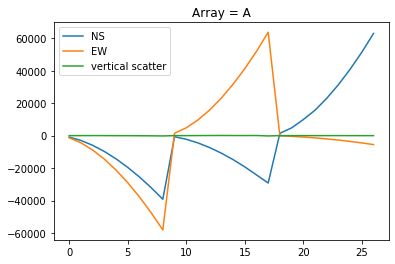

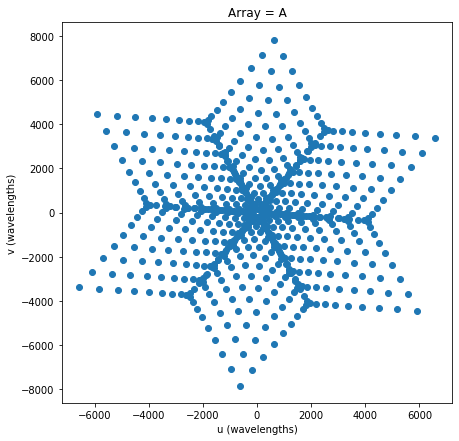

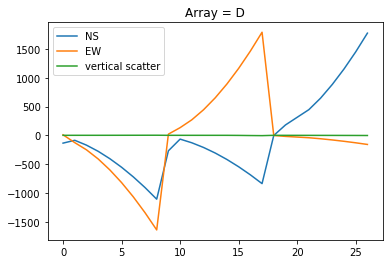

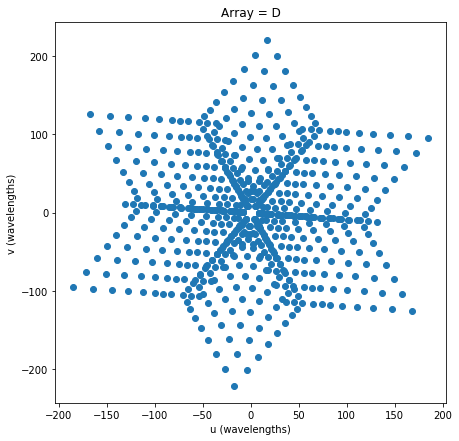

In [422]:
# initialize baselines for the two arrays
B_arrays = []

# loop through arrays
for fname in ['vla_a_array.txt', 'vla_d_array.txt']:
    if fname == 'vla_a_array.txt':
        name = 'A'
    elif fname == 'vla_d_array.txt':
        name = 'D'

    # load VLA data
    dat = np.loadtxt(fname)
    latitude = 34.1*np.pi/180

    # set coordinates, converted to meters
    dat = dat*1e-9*3e8
    x,y,z = dat[:,0], dat[:,1], dat[:,2]

    # convert 3d to 2d 
    antpos = dat[:,:3] # jon thing
    zenith = np.array([np.cos(latitude), 0, np.sin(latitude)])
    east = np.array([0,1,0])
    north = np.cross(zenith, east)

    # rotate 3d to 2d EW/NS coordinates
    rotate = np.vstack([north, east, zenith])
    coords = rotate@np.array([x,y,z])
    check = antpos@rotate.T # jon thing

    # root mean square, in m
    rms = np.sqrt(np.mean((coords[2])**2))
    print('{} array: vertical RMS scatter = {} m'.format(name,rms))

    # plot E/W and N/S in ns
    plt.figure()
    plt.plot(coords[0,:]/(1e-9*3e8), label='NS')
    plt.plot(coords[1,:]/(1e-9*3e8), label='EW')
    plt.plot(coords[2,:]/(1e-9*3e8), label='vertical scatter')
    # check that this is the same as jon's (it is)
    #plt.plot(check[:,0], ls=':') 
    #plt.plot(check[:,1], ls=':') 
    plt.legend()
    plt.title('Array = {}'.format(name))
    
    # get the baselines by subtracting coordinates
    B = []
    for i in range(len(check)):
        for j in range(len(check)):
            if i!=j:
                B.append(list(check[i,:2]-check[j,:2]))
    B = np.array(B)          
    
    # convert baseline to wavelengths
    wavelength = 3e8/1.4e9 # c/nu
    B_scale = B*wavelength
    B_arrays.append(B_scale)

    # plot
    plt.figure(figsize=(7,7))
    #plt.plot(UV[:,0], UV[:,1], ls='', marker='o')
    #plt.plot(B[:,0], B[:,1], ls='', marker='.')
    plt.plot(B_scale[:,0], B_scale[:,1], ls='', marker='o')
    plt.xlabel('u (wavelengths)')
    plt.ylabel('v (wavelengths)')
    plt.title('Array = {}'.format(name))

Fig: The vertical scatter is small for both arrays.

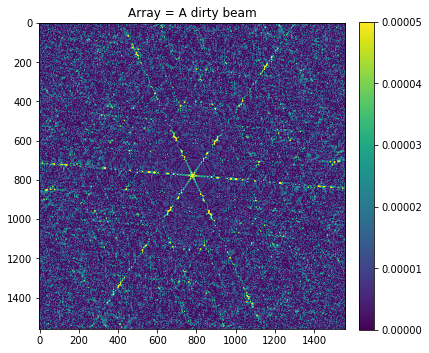

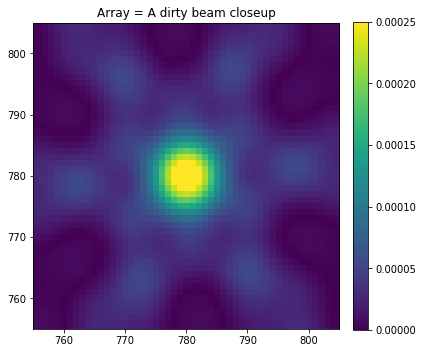

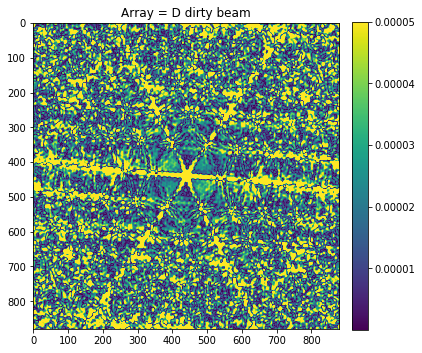

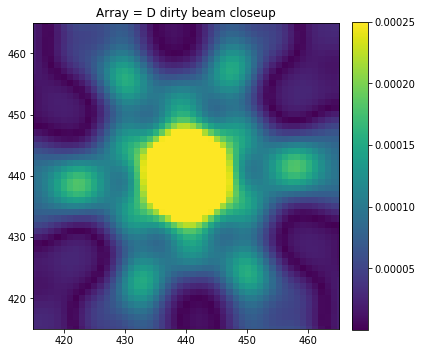

In [294]:
# using Jon's code for filling the matrix with 0s and 1s...

# initialize array of dirty beams and FWHMs
dirty_beams, fwhms = [],[]

for name_i, name in enumerate(['A', 'D']):
    
    # redefine baselines
    B_scale = B_arrays[name_i]

    # set du (for 'a', du=40 and for 'd', du=2)
    if name == 'A':
        du=40
    elif name == 'D':
        du=2

    # not sure why we need to pad
    pad=4
    # not sure what sz is - range of v's and u's maybe?
    sz=int(np.max(np.abs(B_scale))/du)

    # matrix of zeros for UV coverage
    uv_mat=np.zeros([pad*2*sz,2*pad*sz])

    # set indices of the matrix
    uv_int=np.asarray(B_scale/du,dtype='int')

    # loop through pixels
    for i in range(B_scale.shape[0]):

        # fill matrix with ones where we have UV coverage
        uv_mat[uv_int[i,0],uv_int[i,1]]=uv_mat[uv_int[i,0],uv_int[i,1]]+1

    # put the matrix into real space
    uv_mat_real = np.abs(np.fft.ifft2(uv_mat))
    uv_mat_real = np.fft.fftshift(uv_mat_real)
    dirty_beams.append(uv_mat_real)

    # plot the dirty beam
    plt.figure(figsize=(6,6))
    plt.imshow(uv_mat_real, vmax=0.00005)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.title('Array = {} dirty beam'.format(name))

    # zoom in on center to find the FWHM
    mid = len(uv_mat_real)//2

    # constrain to +/- some pixels
    dx = 25 

    # find maximum at center
    uv_max = np.max(uv_mat_real[mid,:])

    # loop until we find the brightness dropped by half
    for i in range(dx):
        if uv_mat_real[mid,mid+i] >= uv_max/2:
            fwhm = 2*np.abs(uv_mat_real[mid,mid] - uv_mat_real[mid,mid+i])
            fwhm_ind = i
        else:
            break
    # check that it's the same for the other direction (it is)
    # for i in range(dx):
    #     if uv_mat_real[mid,mid+i] > uv_max/2:
    #         fwhm, fwhm_ind = uv_mat_real[mid,mid+i], mid+i
    #     else:
    #         break
    fwhms.append(fwhm_ind)
    
    plt.figure(figsize=(6,6))
    plt.imshow(uv_mat_real, vmax=0.00025)
    plt.axvline(fwhm_ind, c='r')
    plt.axhline(fwhm_ind, c='r')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.xlim([mid-dx,mid+dx])
    plt.ylim([mid-dx,mid+dx])
    plt.title('Array = {} dirty beam closeup'.format(name))

FWHM = 8 pixels
FWHM = 8 pixels


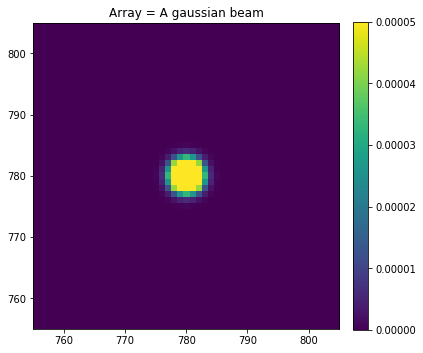

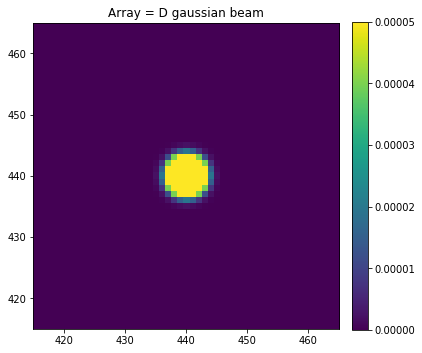

In [295]:
# make the gaussian beam (synthesized beam)

for name_i, name in enumerate(['A', 'D']):
    
    # redefine dirty beam and fwhm index
    uv_mat_real = dirty_beams[name_i]
    fwhm_ind = fwhms[name_i]
    
    # max is the amplitude of the Gaussian beam
    uv_max = np.max(uv_mat_real)
    
    # center point
    mid = len(uv_mat_real)//2

    # fwhm in terms of pixels
    fwhm_pix = 2*fwhm_ind
    print('FWHM = {} pixels'.format(fwhm_pix))
    sigma = fwhm_pix/(8*np.log(2))

    # make matrix of x, y
    n = len(uv_mat_real)
    X, Y = np.arange(n), np.arange(n)
    dX=X-X[mid]
    dY=dX
    dxmat=np.outer(dX,np.ones(len(dX)))
    dymat=np.outer(np.ones(len(dY)),dY)

    # make the 2d gaussian
    rsqr=dxmat**2+dymat**2
    gauss_2d=uv_max*np.exp(-.5*rsqr/sigma**2)

    # plot
    plt.figure(figsize=(6,6))
    plt.imshow(gauss_2d, vmax=0.00005)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.xlim([mid-dx,mid+dx])
    plt.ylim([mid-dx,mid+dx])
    plt.title('Array = {} gaussian beam'.format(name))

Fig: I still need to convert the FWHM from pixels to wavelengths. Also I think there might be a mistake I can't seem to find because the FWHM should be bigger for the D-array (the dirty beam above has a much bigger ~Gaussian).

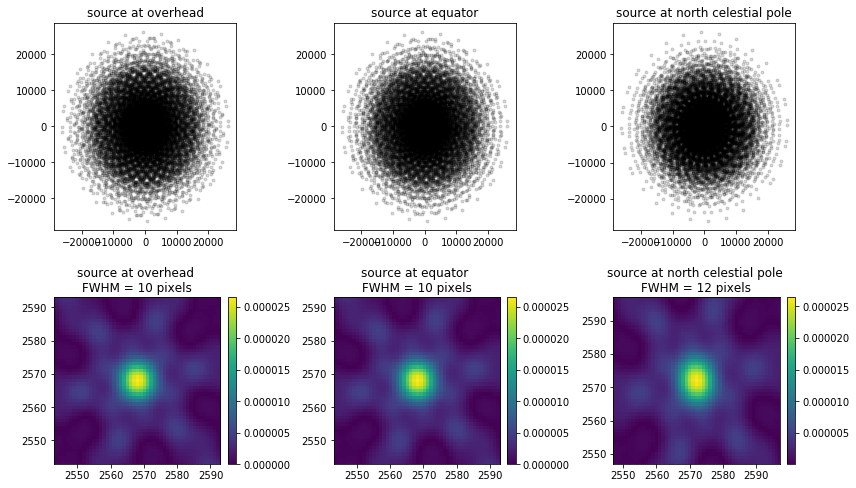

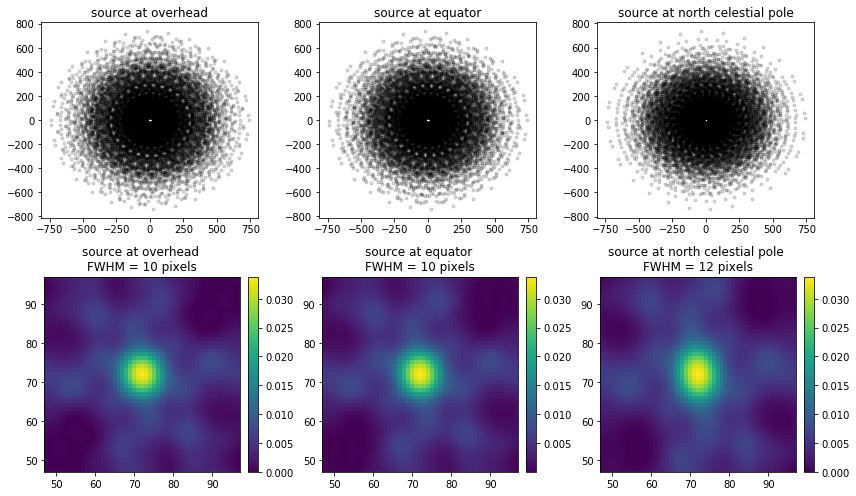

In [296]:
# loop through A/D arrays
for fname in ['vla_a_array.txt', 'vla_d_array.txt']:
    if fname == 'vla_a_array.txt':
        name = 'A'
    elif fname == 'vla_d_array.txt':
        name = 'D'

    # load VLA data
    dat = np.loadtxt(fname)

    # get range of times, take 20 steps?
    t_range = np.linspace(-8,8,20)

    # get range of angles (phi). Earth rotates 2 pi in
    # 24 h (we keep time range in hours)
    phi_range=t_range*2*np.pi/24

    # loop through thetas
    thetas = np.array([34.1, 45, 0])*np.pi/180
    theta_names = ['overhead', 'equator', 'north celestial pole']

    # 1 plot per theta
    fig, axs = plt.subplots(2,3, figsize=(12,7), tight_layout=True)
    axs = axs.ravel()

    for t, theta in enumerate(thetas):

        # split data into arrays for x,y,z
        antpos = dat[:,:3] # jon thing

        # get zenith vector (up-down)
        zenith = np.array([np.cos(theta), 0, np.sin(theta)])

        # get east-west vector
        east = np.array([0,1,0])

        # get north-south vector by taking the cross product
        north = np.cross(zenith, east)

        # rotate 3d to 2d EW/NS coordinates
        rotate = np.vstack([north, east, zenith])
        xyz = antpos@rotate.T

        # get the baselines by subtracting coordinates
        B = []
        for i in range(len(xyz)):
            for j in range(len(xyz)):
                if i!=j:
                    B.append(list(xyz[i,:2]-xyz[j,:2]))
        B = np.array(B)          

        # convert baseline to wavelengths
        wavelength = 3e8/1.4e9 # c/nu
        B_scale = B*wavelength

        # 2d rotation matrix for each phi
        for phi in phi_range:
            rot_2d = np.zeros([2,2])
            rot_2d[0,0] = np.cos(phi)
            rot_2d[0,1] = -np.sin(phi)
            rot_2d[1,0] = np.sin(phi)
            rot_2d[1,1] = np.cos(phi)

            # rotate baselines
            B_rot = B_scale@rot_2d
            #print('B_rot[0,0] = ', B_rot[0,0])

            # plot UV
            axs[t].plot(B_rot[:,0], B_rot[:,1], alpha=0.15, c='k', ls='', marker='.')
            axs[t].set_title('source at {}'.format(theta_names[t]))

            # make the dirty beam
            du=40
            # not sure why we need to pad
            pad=4
            # not sure what sz is - range of v's and u's maybe?
            sz=int(np.max(np.abs(B_rot))/du)
            # matrix of zeros for UV coverage
            uv_mat=np.zeros([pad*2*sz,2*pad*sz])

            # set indices of the matrix
            uv_int=np.asarray(B_rot/du,dtype='int')

            # loop through pixels
            for i in range(B_rot.shape[0]):

                # fill matrix with ones where we have UV coverage
                uv_mat[uv_int[i,0],uv_int[i,1]]=uv_mat[uv_int[i,0],uv_int[i,1]]+1

            # put the matrix into real space
            uv_mat_real = np.abs(np.fft.ifft2(uv_mat))
            uv_mat_real = np.fft.fftshift(uv_mat_real)

            # get the synthesized beam for the center phi
            if phi == phi_range[len(phi_range)//2]:

                # zoom in on center to find the FWHM
                mid = len(uv_mat_real)//2

                # constrain to +/- some pixels
                dx = 25 

                # find maximum at center
                uv_max = np.max(uv_mat_real[mid,:])

                # loop until we find the brightness dropped by half
                for i in range(dx):
                    # look along the y-axis this time?
                    if uv_mat_real[mid+i,mid] >= uv_max/2:
                        fwhm = 2*np.abs(uv_mat_real[mid,mid] - uv_mat_real[mid+i,mid])
                        fwhm_ind = i
                    else:
                        break

                # fwhm in terms of pixels
                fwhm_pix = 2*fwhm_ind
                sigma = fwhm_pix/(8*np.log(2))

                # make matrix of x, y
                n = len(uv_mat_real)
                X, Y = np.arange(n), np.arange(n)
                dX=X-X[mid]
                dY=dX
                dxmat=np.outer(dX,np.ones(len(dX)))
                dymat=np.outer(np.ones(len(dY)),dY)

                # make the 2d gaussian
                rsqr=dxmat**2+dymat**2
                gauss_2d=uv_max*np.exp(-.5*rsqr/sigma**2)

                # plot the dirty beam
                im = axs[t+3].imshow(uv_mat_real)
                #im = axs[t+3].imshow(gauss_2d, vmax=0.00005)
                fig.colorbar(im, ax=axs[t+3], fraction=0.046, pad=0.04)
                axs[t+3].set_xlim([mid-dx,mid+dx])
                axs[t+3].set_ylim([mid-dx,mid+dx])
                axs[t+3].set_title('source at {} \nFWHM = {} pixels'.format(theta_names[t], fwhm_pix))        

Fig: I noticed that the beams aren't perfectly circular (the north celestrial pole in particular looks skewed), so I looked for the FWHM (in pixels) along the y-direction.

# Problem 2

*(a) Estimate the field of view of the VLA at 1.4 GHz and 8 GHz.*

Is this a calculation involving $\frac{1.22 \lambda}{D}$ where $D$ is the effective diameter of the array and $\lambda = c/\nu$ with $\nu = 1.4 \times 10^9 \text{ Hz , } 8 \times 10^9 \text{ Hz}$?

*(b) For a source directly overhead, calculate the difference in distance each baseline for the overhead source and a source 30 arcmin to the south. Assume the path length difference is given by the dot product of the source angle and the 2D UV coordinates of the antennas.*

The path length difference is the dot product of the (u,v) vector with the $\theta$ vector, which is $(sin \theta, cos \theta)$ with $\theta = $ 0 degrees for the overhead source, and 30 arcminutes for the other source.

*(c) Repeat but use the full 3D antenna positions. What is the RMS difference between these path length differences and the differences you calculated in b? So for a single baseline you would calculate the UV coordinate for the baseline in a coordinate system pointed at source no. 1 in (b), you calculate the difference in path length between source no. 1 and source no. 2 assuming you keep the same UV coordinates. In (c) you use the full 3D antenna positions (so no UV coordinate system anymore) but you still report the path length difference for the baseline to source 1 and 2. If the difference between these two differences is small compared to a wavelength, we can ignore the w term.*

The path length difference is now the dot product of the (u,v,w) vector with the $\theta$ (source) vector, which is $(0,sin \theta, cos \theta)$ (from taking $\phi = 0$). Then we look at the path difference-difference between these two sources, which is in m, and compare to the wavelength for 1.4 GHz.

*(d) Now that you are set up to do this, report the RMS phase difference for a source 1 FWHM from the pointing center at both 1.4 and 8 GHz when the pointing center is 1. directly overhead, and 2. at the equator. For which of these cases will you need to worry about the w term for both A and D arrays?*

I'm not sure what 1 FWHM is, but the phase difference is the path length difference divided by the wavelength. (Skipping this part of the problem).

RMS path length difference = 11491.111266112744 (array A, source overhead)
RMS path length difference = 11491.812832141793 (array A, source at 30 arcmin)
RMS path length difference = 323.94384578179205 (array D, source overhead)
RMS path length difference = 323.95873040057046 (array D, source at 30 arcmin)


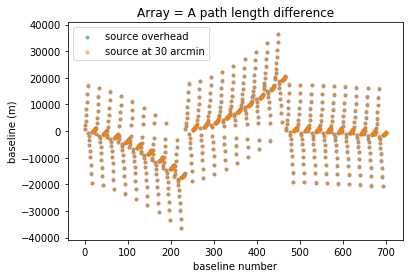

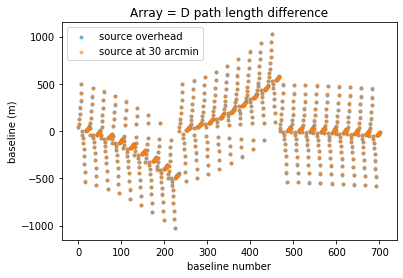

In [325]:
# initialize array of path length differences
path_diffs = []

# loop through arrays
for name_i, name in enumerate(['A', 'D']):
    
    # one plot per array
    plt.figure()
    
    # redefine baselines
    B_scale = B_arrays[name_i]
    
    # convert back from wavelengths to meters
    wavelength = 3e8/1.4e9 # c/nu
    B_meters = B_scale/wavelength
    
    # 30 arcminute source angle (arcmin to degree to radians)
    theta2 = 30*(1/60)*np.pi/180
    
    # loop through two thetas
    for theta in [0, theta2]:
        
        if theta==0:
            theta_label='overhead'
        elif theta==theta2:
            theta_label='at 30 arcmin'
        
        # source vector
        source_vec = np.array([np.sin(theta), np.cos(theta)])
        
        # path length difference
        path_diff = B_meters@source_vec
        path_diffs.append(path_diff)
        
        # print RMS path length difference
        rms = np.sqrt(np.mean(path_diff**2))
        print('RMS path length difference = {} (array {}, source {})'.format(rms,name,theta_label))
        
        # plot them?
        plt.scatter(np.arange(len(path_diff)), path_diff, 
                    marker='.', alpha=0.5, label='source {}'.format(theta_label))
        plt.legend()
        plt.title('Array = {} path length difference'.format(name))
        plt.ylabel('baseline (m)')
        plt.xlabel('baseline number')

Should these path length differences be smaller?

RMS path length difference difference between sources = 4.6282495755974375 m (array A)
RMS path length difference difference between sources = 0.1604903558854516 m (array D)


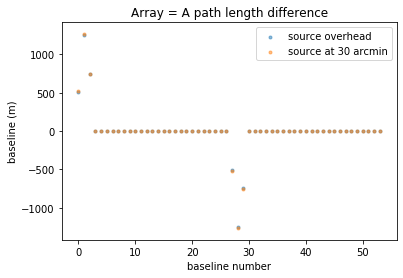

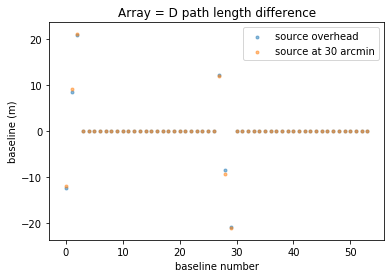

In [397]:
# loop through arrays
for fname in ['vla_a_array.txt', 'vla_d_array.txt']:
    if fname == 'vla_a_array.txt':
        name = 'A'
    elif fname == 'vla_d_array.txt':
        name = 'D'

    # load VLA data
    dat = np.loadtxt(fname)
    # convert to meters
    dat = dat*1e-9*3e8
    
    # 3d coordinates
    antpos = dat[:,:3]
    
    # 3d baselines (mostly Jon code)
    uv_3d=np.zeros(antpos.shape)
    icur=0
    for i in range(antpos.shape[1]):
        for j in range(i+1,antpos.shape[1]):
            # baselines are the differences in coordinates
            uv_3d[icur,:]=antpos[i,:]-antpos[j,:]
            icur=icur+1
    uv_3d=np.vstack([uv_3d,-uv_3d])
    
    # source vector is now (0, sin(theta), cos(theta))
    # 30 arcminute source angle (arcmin to degree to radians)
    theta2 = 30*(1/60)*np.pi/180
    
    # initialize path length differences for 2 sources
    path_diffs_2 = []
    
    # one plot per array
    plt.figure()
    
    # loop through two thetas
    for theta in [0, theta2]:
        
        if theta==0:
            theta_label='overhead'
        elif theta==theta2:
            theta_label='at 30 arcmin'
        
        # source vector
        source_vec = np.array([0, np.sin(theta), np.cos(theta)])
        
        # path length difference
        path_diff = uv_3d@source_vec
        path_diffs_2.append(path_diff)
        
        # plot
        plt.scatter(np.arange(len(path_diff)), path_diff, 
                    marker='.', alpha=0.5, label='source {}'.format(theta_label))
        plt.legend()
        plt.title('Array = {} path length difference'.format(name))
        plt.ylabel('baseline (m)')
        plt.xlabel('baseline number')
        #plt.ylim(-0.1,0.1)
        
    # difference in path length differences
    path_diffdiffs = path_diffs_2[1] - path_diffs_2[0]
    
    # get RMS
    RMS = np.sqrt(np.mean(path_diffdiffs**2))
    print('RMS path length difference difference between sources = {} m (array {})'.format(RMS, name))

In [349]:
print('1.4 GHz = wavelength of ', wavelength)

1.4 GHz = wavelength of  0.21428571428571427


For a wavelength of around 0.2 m, the RMS differences are way too high to ignore w in the A-array. But it looks like we can ignore it for the D-array?

# Problem 3

*Assume we're working at 1.4 GHz and take the UV coverage for the VLA for a source directly overhead. Take a second source separated by 1 FWHM to the south. As we change observing frequency, the UV coordinates in wavelengths will change. By how much do we need to shift the frequency to make the RMS path length difference change by $\lambda / 2 \pi$ for both A and D arrays? (Bandwidth smearing).*

I'm taking 1 FWHM to be $1.22 \lambda / D$ with $D = 130 \text{ m}$, converted from degrees to radians. Then using the above code to get the RMS path length differences for a source at $\theta = 0$ and $\theta = $ 1 FWHM. I loop through frequencies until we get to $\lambda/2 \pi$, but use $\lambda = c/(1.4 \times 10^9)$ Hz. (This didn't work, I'm not sure what I'm supposed to do).

In [409]:
#freqs = np.linspace(1.4e9, 0.3e7, 50)
#freqs = np.linspace(1.4e9, 0.298e7, 50)
freqs = np.linspace(1.4e6, 1.4e9, 50)

# loop through arrays
for fname in ['vla_a_array.txt', 'vla_d_array.txt']:
    if fname == 'vla_a_array.txt':
        name = 'A'
    elif fname == 'vla_d_array.txt':
        name = 'D'

    # load VLA data
    dat = np.loadtxt(fname)
    # convert to meters
    dat = dat*1e-9*3e8
    
    # 3d coordinates
    antpos = dat[:,:3]
    
    # 3d baselines (mostly Jon code)
    uv_3d=np.zeros(antpos.shape)
    icur=0
    for i in range(antpos.shape[1]):
        for j in range(i+1,antpos.shape[1]):
            # baselines are the differences in coordinates
            uv_3d[icur,:]=antpos[i,:]-antpos[j,:]
            icur=icur+1
    uv_3d=np.vstack([uv_3d,-uv_3d])
    
    # convert to wavelength units
    wavelength = 3e8/nu
    uv_3d = uv_3d*wavelength
    
    # loop through frequencies
    for nu in freqs:
        
        # lambda/2 pi limit
        lim = (3e8/nu)/(2*np.pi)
    
        # FWHM in radians
        diameter = 130
        FWHM = 1.22*3e8*(1/1.4e9)/diameter
        FWHM = FWHM*(np.pi/180)
        theta2 = FWHM

        # initialize path length differences for 2 sources
        path_diffs_2 = []

        # loop through two thetas
        for theta in [0, theta2]:

            if theta==0:
                theta_label='overhead'
            elif theta==theta2:
                theta_label='at 30 arcmin'

            # source vector is (0, sin(theta), cos(theta))
            source_vec = np.array([0, np.sin(theta), np.cos(theta)])

            # path length difference
            path_diff = uv_3d@source_vec
            path_diffs_2.append(path_diff)

        # difference in path length differences
        path_diffdiffs = path_diffs_2[1] - path_diffs_2[0]

        # get RMS
        RMS = np.sqrt(np.mean(path_diffdiffs**2))
        
        # continue loop if RMS is less than the lambda/2 pi limit
        if RMS < lim:
            nu_smear = nu
            #print('RMS = {}, limit = {}'.format(RMS, lim))
        elif RMS > lim:
            break

# Problem 4

Rule of thumb: you hit the confusion limit at one visible source for every 30 beams. Start with first having 100 sources per square degree above 1 mJy at 1.4 GHz.

*(a) Assuming Euclidean counts, show that the number of sources brighter than some flux limit $N(S) > S \propto S^{-3/2}$. Easiest way to do this is assume all sources have same brightness, and are uniformly distributed in space. Then calculate the volume in which you would observe a source. Assume counts are Euclidean for the rest of the problem.*

If we have some number of sources in a volume ~$r^3$, doubling sensitivity means the radius of this volume doubles. The flux is inversely proportional to $r^2$, so the number of sources brighter than some flux limit is proportional to $S^{-3/2}$

*(b) For GBT (100 m diameter), FAST (effective diameter 300m) and VLA in A and D arrays, what is the confusion level using the source-per-30 beams rule?*

I'm confused about Jon's slide for this calculation. The confusion limit is $\sqrt{\text{sources per beam}} \times (\text{100 sources})$. But if we have one source per 30 beams, how do we use the diameters to do this calculation for difference arrays?

*(c) How long would each telescope be able to integrate before hitting the confusion limit? Assume $T_{sys}$ is 25 degrees, bandwidth of 500 MHz, and aperture efficiency of 70%.*

Integration time is $t = (\frac{T}{dT})^2 /B$ where $B$=500 MHz and say $dT$ is double the confusion limit to get from mJy to mK.

*(d) Repeat (b) and (c) but for an observing frequency of 8 GHz and a bandwidth of 2 GHz. Assume all sources have a spectral index of -0.8 so a source at 8 GHz has a flux $(8/1.4)^{-0.8}$ times its flux at 1.4 GHz.*

(This part is not done).

In [416]:
def conf_limit(diameter, nu=1.4e9):
    
    # wavelength, in meters
    wavelength = 3e8/nu
    
    # calculate beam size, in arcminutes
    beam_size = 1.22*wavelength/diameter
    beam_size = beam_size*60**2
    
    # sources per beam (100 sources)
    source_per_beam = 100*(beam_size/60)**2
    
    # confusion limit (1 mJy)
    conf_lim = np.sqrt(source_per_beam)*1
    
    return conf_lim

def int_time(diameter, nu=1.4e9, B=500e6):
    
    # 70% efficiency - so scale diameter by 0.7
    diameter = 0.7*diameter
    
    # wavelength, in meters
    wavelength = 3e8/nu
    
    # calculate beam size, in arcminutes
    beam_size = 1.22*wavelength/diameter
    beam_size = beam_size*60**2
    
    # sources per beam (100 sources)
    source_per_beam = 100*(beam_size/60)**2
    
    # confusion limit (1 mJy)
    conf_lim = np.sqrt(source_per_beam)*1
    
    # convert to K to get dT
    dT = conf_lim*2*1e-3
    
    # get integration time
    t = (25/conf_lim)**2/B
    
    return t

In [418]:
# go through GBT (100 m), FAST (300 m), and VLA (130 m)

names = ['GBT', 'FAST', 'VLA']
diameters = [100, 300, 130]

for i, diameter in enumerate(diameters):
    
    # confusion limit
    conf_lim = conf_limit(diameter)
    print('{} has confusion limit = {} mJy'.format(names[i], conf_lim))
    
    # integration time
    t = int_time(diameter)
    print('{} has integration time of {} s\n'.format(names[i], t))

GBT has confusion limit = 1.5685714285714285 mJy
GBT has integration time of 2.489416093509976e-07 s

FAST has confusion limit = 0.5228571428571428 mJy
FAST has integration time of 2.2404744841589777e-06 s

VLA has confusion limit = 1.2065934065934063 mJy
VLA has integration time of 4.2071131980318584e-07 s



These all seem wrong.